# A/B тестирование

## Контекст задачи

Аналитики торговой площадки Авито тестируют новое предложение для пользователей, которое принесет до 10 % прибыли. То есть новое предложение будет успешным, если оно повысит коэффициент конверсии до 10%.

## Формулировка гипотезы

Hо: p(a) = p(b)

H1: p(a) ≠ p(b)

где p(a) и p(b) означают соответственно коэффициент конверсии прежнего предложения и нового предложения. Мы также установим уровень доверия 95%, то есть α = 0,05

Значение α - это порог ошибки первого рода, который мы устанавливаем и делаем вывод: «Если вероятность наблюдения за результатом (p-value) ниже α, то мы отвергаем гипотезу Hо». Поскольку наша α=0,05 (что указывает на вероятность 5%), наша уверенность (1 — α) составляет 95%.

В результате решения данной задачи, мы хотим быть на 95% уверены, что новое предложение повысит коэффициент конверсии до 10%, прежде чем отклонить нулевую гипотезу Ho.

## Набор данных

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('ad.csv')

In [4]:
df.head()

,ad_id,action
0,B,1
1,B,1
2,A,0
3,B,0
4,A,1


Описание набора данных:

A - контрольная группа

B - тестовая группа

action:

0 - не было покупки

1 - была покупка

<AxesSubplot:xlabel='action', ylabel='Count'>

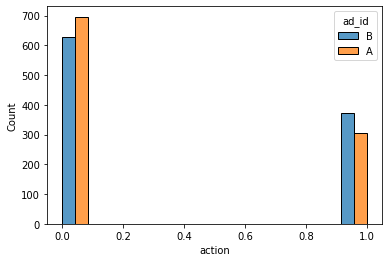

In [5]:
#распределение значений
sns.histplot(data=df, x="action", hue="ad_id", multiple="dodge")

In [6]:
#сумма по группам
summary_df = df.pivot_table(values='action', index = 'ad_id', aggfunc=np.sum)
summary_df

,action
ad_id,
A,304
B,372


In [7]:
#добавим столбцы с расчетом кол-ва элементов по каждой группе и среднему (коэф-т конверсии)
summary_df['total_count'] = df.pivot_table(values='action', index='ad_id', aggfunc=lambda x: len(x))

summary_df['conversion_rate'] = df.pivot_table(values='action', index='ad_id') #по-умолчанию среднее

In [10]:
#Вычислим стандартное отклонение и ошибку(std / sqrt(n)) для каждой группы
summary_df['std_p'] = df.pivot_table(values='action', index='ad_id', aggfunc = lambda x: np.std(x, ddof=0))
summary_df['se_p'] = df.pivot_table(values='action', index='ad_id', aggfunc = lambda x: stats.sem(x, ddof=0))

In [11]:
summary_df

,action,total_count,conversion_rate,std_p,se_p
ad_id,,,,,
A,304,1000,0.304,0.459983,0.014546
B,372,1000,0.372,0.483338,0.015285


Text(0, 0.5, 'Коэф-т конверсии')

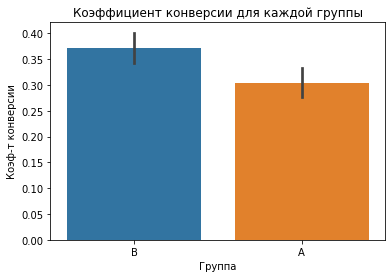

In [15]:
sns.barplot(x=df['ad_id'], y=df['action'])

plt.title('Коэффициент конверсии для каждой группы')
plt.xlabel('Группа')
plt.ylabel('Коэф-т конверсии')

Предложение B лучше, чем A (conversion_rate B > conversion_rate A)

## Проверка гипотезы

Используем критерий Z-статистики для конверсии
Пришло время оценить, насколько разница в конверсии, которую мы получили на собранных данных, статистически значима. То есть, можем ли мы быть уверены, что разница, которую мы наблюдаем — неслучайная.

Z-статистика — критерий, который подходит для оценки конверсии, поскольку данные конверсии дискретные: пользователь либо совершил покупку, и мы присвоили ему 1, либо не совершил и мы присвоили ему 0.

In [17]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [18]:
#Выделяем явно группы: контрольная А, тестовая В
control_results = df[df['ad_id'] == 'A']['action']
test_results = df[df['ad_id'] == 'B']['action']

In [19]:
#Считаем кол-во элементов в каждой группе
#все пользователи из колонки
nobs = [control_results.count(), test_results.count()]

#Считаем кол-во покупок в каждой группе
successes = [control_results.sum(), test_results.sum()]

z_stat, pval = proportions_ztest(successes, nobs)

print('z statistic:', z_stat)
print('p-value:', pval)

z statistic: -3.2144492244084213
p-value: 0.0013069502732125403


Если p-value (pval) меньше порога ошибки первого рода — результат эксперимента можно считать статзначимым.
Если p-value больше — мы будем вынуждены признать разницу в значениях тестовой и контрольной группы случайной

In [21]:
#порог ошибки
alpha = 0.05

In [22]:
print(pval < alpha)

True


In [23]:
(lower_con, lower_test), (upper_con, upper_test) = proportion_confint(successes, nobs=nobs, alpha=alpha)

print('Доверительный интервал для контрольной группы A:', lower_con, ' - ', upper_con)
print('Доверительный интервал для тестовой группы B:', lower_test, ' - ', upper_test)

Доверительный интервал для контрольной группы A: 0.2754905064387712  -  0.3325094935612288
Доверительный интервал для тестовой группы B: 0.3420429266473629  -  0.4019570733526371


Вывод: новое предложение увеличит прибыль до 10% 